In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Code for Oja's algorithm

Here is the code for logging algorithm iterations (class Oja) and several possible optimizers for different steps.

In [2]:
# helpfull functions
def positive_semidefined(d):
    A = np.random.randn(d,d)
    U,_,_ = np.linalg.svd(A)
    D = np.diag(1/(np.arange(d)+1))
    A = U@D@U.T
    return A

def get_stream(A):
    d = A.shape[0]
    while True:
        v = np.random.randn(d,1)
        yield A@v@v.T@A.T

def delta_lambda(A):
    eigenvalues = np.linalg.eigvals(A)
    eigenvalues = sorted(eigenvalues, reverse=True)
    return eigenvalues[0], eigenvalues[0] - eigenvalues[1]

def max_eigenvec(A):
    eigenvalues, eigenvectors = np.linalg.eig(A)
    max_eig = np.argmax(eigenvalues)
    real_w = eigenvectors[:, max_eig].reshape(-1, 1)
    real_w /= np.linalg.norm(real_w, 2)
    return real_w

In [3]:
# class for running Oja's algorithm
class Oja:
    def __init__(self, d, optimizer, weight=None):
        if weight is None:
            self.weight = np.random.uniform(size=(d, 1))
            self.weight /= np.linalg.norm(self.weight, 2)
        else:
            self.weight = weight
        self.optimizer = optimizer
        self.weight_log = [self.weight, ]
        
    def update(self, A):
        self.weight = self.optimizer.step(self.weight, A)
        self.weight /= np.linalg.norm(self.weight, 2)
        self.weight_log.append(self.weight)
        
    def run(self, a_stream, max_iter = 1000):
        assert len(self.weight_log) == 1, 'Trying to run second time'
        for i in range(max_iter):
            A = next(a_stream)
            self.update(A)
        return self.weight
    
    def loss_history(self, reference_w):
        loss_h = []
        for w in self.weight_log:
            loss_h.append((1 - (w.T @ reference_w) ** 2).item())
        return loss_h
    
    def rayleigh_quotient_history(self, A0):
        rq_h = []
        for w in self.weight_log:
            rq_h.append((w.T @ A0 @ w).item())
        return rq_h
    
    def pretty_plot(self, A0, plot_mode=plt.loglog):
        real_w = max_eigenvec(A0)
        
        loss = self.loss_history(real_w)
        rq = self.rayleigh_quotient_history(A0)
        
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.title('Rayleigh quotient')
        plot_mode(rq)
        plt.grid()
        
        plt.subplot(1, 2, 2)
        plt.title('sin^2(w, real_w)')
        plot_mode(loss)
        plt.grid()
        

In [4]:
# Optimizers
class SGD:
    def __init__(self, lr=1e-2):
        self.lr = lr
    
    def step(self, w, A):
        return w + self.lr * A @ w
    
    def info(self):
        return f'SGD with constant lr={self.lr}'
    
class SGD_with_decreasing_step:
    def __init__(self, lr=1e-2, beta=1):
        self.lr = lr
        self.beta = beta
        self.t = 0
    
    def step(self, w, A):
        temp_lr = self.lr/(self.t + self.beta)
        self.t += 1
        
        return w + temp_lr * A @ w
    
    def info(self):
        return f'SGD with stepsize decrease lr/(beta + t) at every step, lr={self.lr}, beta={self.beta}'
    
class AcSGD:
    def __init__(self, alpha=1e-2, beta=1e-2):
        self.alpha = alpha
        self.beta = beta
        self.z = None
        self.t = 0
    
    def step(self, w, A):
        if self.t == 0:
            self.z = w
        
        y = w + self.beta * A @ w
        self.z = self.z + self.alpha * (self.t + 1) * A @ w
        
        return ((self.t + 1) * y + self.z) / (self.t + 2)
    
    def info(self):
        return f'AcSGD with alpha={self.alpha}, beta={self.beta}'   

class AcSGD_with_decreasing_step:
    def __init__(self, alpha=1e-2, beta=1e-2, gamma=1, decrease_mod='1/t'):
        def alpha_gen(alpha, gamma=gamma):
            t = 0
            while True:
                t += 1
                yield alpha/(t**gamma)
                
        def beta_gen(beta, gamma=gamma):
            t = 0
            while True:
                t += 1
                yield beta/(t**gamma)
                
        self.alpha_gen = alpha_gen(alpha)
        self.beta_gen = beta_gen(beta)
        self.alpha = alpha
        self.beta = beta
        self.z = None
        self.t = 0
    
    def step(self, w, A):
        if self.t == 0:
            self.z = w
        
        y = w + next(self.beta_gen) * A @ w
        self.z = self.z + next(self.alpha_gen) * (self.t + 1) * A @ w
        
        return ((self.t + 1) * y + self.z) / (self.t + 2)
    
    def info(self):
        return f'AcSGD with alpha={self.alpha}, beta={self.beta}'

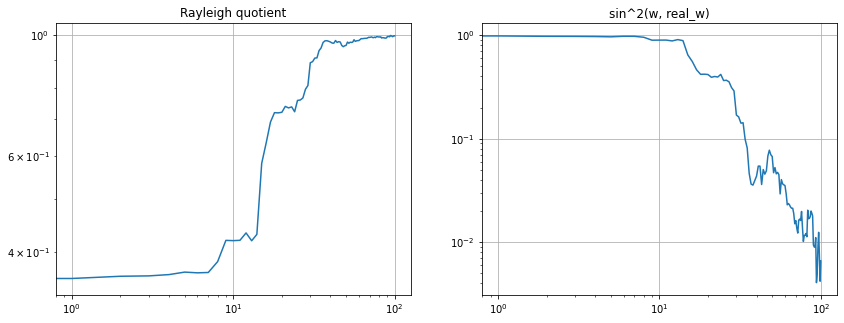

In [5]:
# Usage example
d = 3
l = 1

# creating positive semidefined matrix
A = positive_semidefined(d)

# generator for A_n (to get next iteration run "next(a_stream)")
a_stream = get_stream(A)

optimizer = AcSGD(alpha=0.1, beta=0.1) # create optimizer with desired parameters
oja = Oja(d, optimizer) # set dimension for the weights and optimizer to use
oja.run(a_stream, max_iter=100) # run max_iter steps of Oja's algorithm
oja.pretty_plot(A,plt.loglog) # plot to see how good it did (you need to provide true value of A)

### Time for testing

In [5]:
MAX_ITER = 10**3

def make_test_case(d):
    A = positive_semidefined(d)

    a_stream = get_stream(A)
    
    return {
        'd': d,
        'A': A, 
        'A_stream': a_stream
    }

In [6]:
# define parameters for which we will conduct experiments 
# d - matrix dimension, l - lenths of the interval for uniform distribtion
ds = [10, 50]

test_cases = [make_test_case(d) for d in ds]

In [7]:
def run_test_case(test_case, initial_weight, optimizer_class, optim_params, plot=True):
    optimizer = optimizer_class(**optim_params)
    oja = Oja(test_case['d'], optimizer, initial_weight)
    oja.run(test_case['A_stream'], max_iter=MAX_ITER)
    if plot:
        oja.pretty_plot(test_case['A'])
    return oja

### Constant learning rate

In [9]:
sgd_params = [{'lr': 1e-1}, {'lr': 1e-2}, {'lr': 1e-3}]

sgd_results = []
for optim_params in sgd_params:
    for test_case in test_cases:
        sgd_results.append((run_test_case(test_case, None, SGD, optim_params, plot=False), test_case['A']))

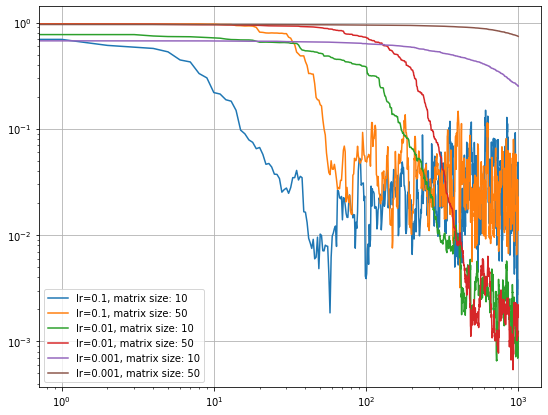

In [10]:
plt.figure(figsize=(9, 7))
for res in sgd_results:
    real_w = max_eigenvec(res[1])    
    loss = res[0].loss_history(real_w)
    label = res[0].optimizer.info().split()[-1] + f', matrix size: {res[1].shape[0]}'
    plt.loglog(loss, label=label)
    #plt.ylim((-1e-4, 0.001)) 
plt.grid()
plt.legend()

### Learning rate of n-th iteration = const / (beta + n)

In [11]:
lrs = [1e-1, 1]
betas = [1, 10, 100]
sgd_with_step_decrease_params = []
sgd_with_step_decrease = []

for lr in lrs:
    for beta in betas:
        sgd_with_step_decrease_params.append({'lr': lr, 'beta':beta})
        
for test_case in test_cases:
    for sgd_with_step_decrease_param in sgd_with_step_decrease_params:
        sgd_with_step_decrease.append(
            (run_test_case(test_case, 
                           None, 
                           SGD_with_decreasing_step, 
                           sgd_with_step_decrease_param, 
                           plot=False
                          ), 
             test_case['A']
            ))

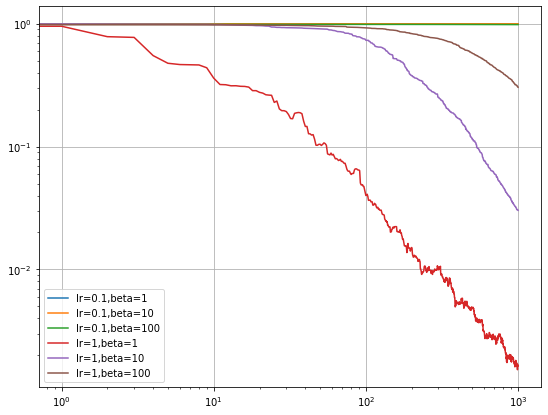

In [12]:
plt.figure(figsize=(9, 7))
for res in sgd_with_step_decrease:
    real_w = max_eigenvec(res[1])    
    loss = res[0].loss_history(real_w)
    if res[1].shape[0] == 50:
        label = res[0].optimizer.info().split()[-2] + res[0].optimizer.info().split()[-1]
        plt.loglog(loss, label=label)
    
plt.grid()
plt.legend()

### AcSGD

Note that it works and converges fast

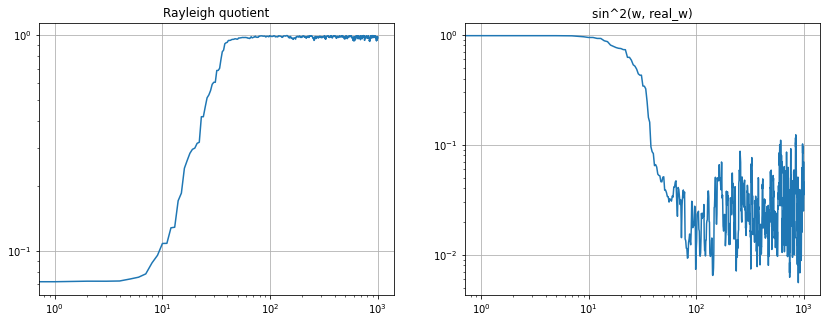

In [13]:
alpha,beta = .1,.1

optimizer = AcSGD(alpha,beta)
oja = Oja(test_cases[1]['d'], optimizer)
oja.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)
oja.pretty_plot(test_cases[1]['A'])

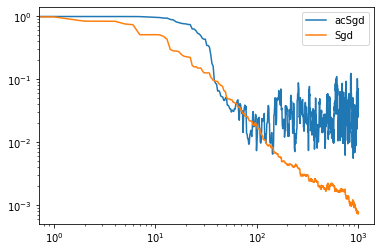

In [14]:
lr = .1
sgd = SGD_with_decreasing_step(lr=1, beta=1)
oja_sgd = Oja(test_cases[1]['d'], sgd)
oja_sgd.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)

real_w = max_eigenvec(test_cases[1]['A']) 

loss_acSgd = oja.loss_history(real_w)
loss_sgd = oja_sgd.loss_history(real_w)
plt.loglog(loss_acSgd, label='acSgd')
plt.loglog(loss_sgd, label='Sgd')
plt.legend()

## AcSGD with decreasing step

If decrease is $\frac{\alpha}{t}$, $\frac{\beta}{t}$ then it is the same as SGD with decreasing step

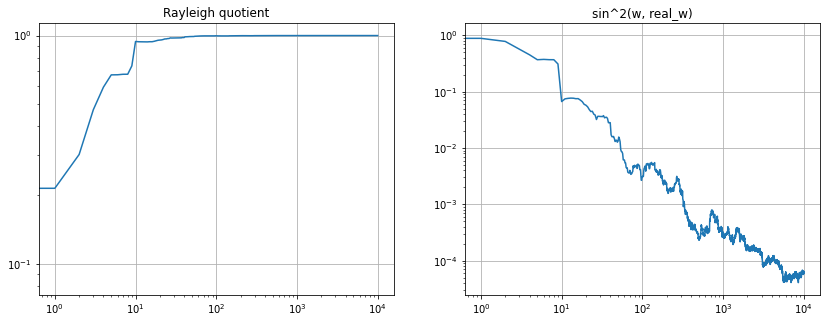

In [15]:
MAX_ITER = 10000

alpha,beta = 1,1

optimizer = AcSGD_with_decreasing_step(alpha,beta)
oja = Oja(test_cases[1]['d'], optimizer)
oja.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)
oja.pretty_plot(test_cases[1]['A'])

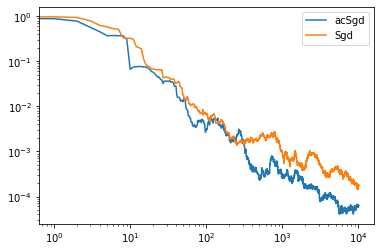

In [16]:
sgd = SGD_with_decreasing_step(lr=1, beta=1)
oja_sgd = Oja(test_cases[1]['d'], sgd)
oja_sgd.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)

real_w = max_eigenvec(test_cases[1]['A']) 

loss_acSgd = oja.loss_history(real_w)
loss_sgd = oja_sgd.loss_history(real_w)
plt.loglog(loss_acSgd, label='acSgd')
plt.loglog(loss_sgd, label='Sgd')
plt.legend()

100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


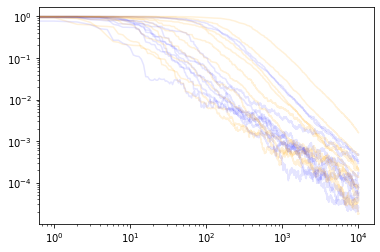

In [17]:
from tqdm import tqdm

loss_acSgd = []
loss_sgd = []
TRIALS = 10
for i in tqdm(range(TRIALS)):
    oja = run_test_case(test_cases[1], None, AcSGD_with_decreasing_step, {'alpha':alpha, 'beta':beta}, False)
    oja_sgd = run_test_case(test_cases[1], None, SGD_with_decreasing_step, {'lr': 1, 'beta':1}, False)
    
    real_w = max_eigenvec(test_cases[1]['A']) 

    loss_acSgd.append(oja.loss_history(real_w))
    loss_sgd.append(oja_sgd.loss_history(real_w))
    
for i in range(TRIALS):
    plt.loglog(loss_acSgd[i], color='blue', alpha=0.1)
    plt.loglog(loss_sgd[i], color='orange', alpha=0.15)

#### When $\gamma \neq 1$

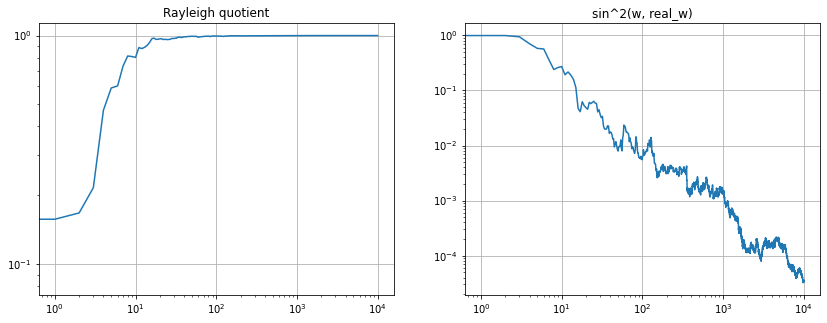

In [19]:
MAX_ITER = 10000

alpha,beta,gamma = 10,1,1.2

optimizer = AcSGD_with_decreasing_step(alpha, beta, gamma)
oja = Oja(test_cases[1]['d'], optimizer)
oja.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)
oja.pretty_plot(test_cases[1]['A'])

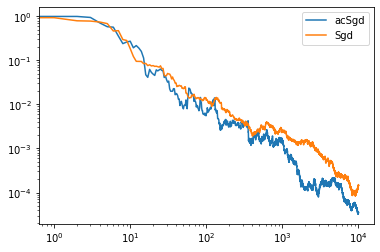

In [23]:
sgd = SGD_with_decreasing_step(lr=1, beta=1)
oja_sgd = Oja(test_cases[1]['d'], sgd)
oja_sgd.run(test_cases[1]['A_stream'], max_iter=MAX_ITER)

real_w = max_eigenvec(test_cases[1]['A']) 

loss_acSgd = oja.loss_history(real_w)
loss_sgd = oja_sgd.loss_history(real_w)
plt.loglog(loss_acSgd, label='acSgd')
plt.loglog(loss_sgd, label='Sgd')
plt.legend()

100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


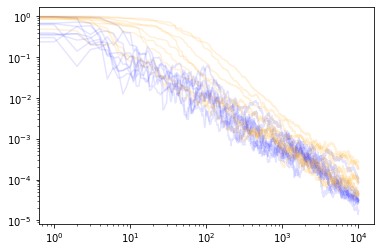

In [24]:
from tqdm import tqdm


loss_acSgd = []
loss_sgd = []
TRIALS = 10
for i in tqdm(range(TRIALS)):
    oja = run_test_case(test_cases[1], None, AcSGD_with_decreasing_step, {'alpha':alpha, 'beta':beta, 'gamma':gamma}, False)
    oja_sgd = run_test_case(test_cases[1], None, SGD_with_decreasing_step, {'lr': 1, 'beta':1}, False)
    
    real_w = max_eigenvec(test_cases[1]['A']) 

    loss_acSgd.append(oja.loss_history(real_w))
    loss_sgd.append(oja_sgd.loss_history(real_w))
    
for i in range(TRIALS):
    plt.loglog(loss_acSgd[i], color='blue', alpha=0.1)
    plt.loglog(loss_sgd[i], color='orange', alpha=0.15)

In [28]:
TRIALS = 20
better_params = []
for alpha in [1, 5, 10]:
    for beta in [1, 5, 10]:
        for gamma in [1.1, 1.3]:
            sum_dif = 0
            for i in tqdm(range(TRIALS)):
                oja = run_test_case(test_cases[1], None, AcSGD_with_decreasing_step, {'alpha':alpha, 'beta':beta, 'gamma':gamma}, False)
                oja_sgd = run_test_case(test_cases[1], None, SGD_with_decreasing_step, {'lr': 1, 'beta':1}, False)

                real_w = max_eigenvec(test_cases[1]['A']) 
                sum_dif += np.mean(oja.loss_history(real_w)[-100:]) - np.mean(oja_sgd.loss_history(real_w)[-100:])
                
            if sum_dif < 0:
                better_params.append((sum_dif / TRIALS, {'alpha':alpha, 'beta':beta, 'gamma':gamma}))
better_params

100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


[(-5.3978428606371806e-05, {'alpha': 1, 'beta': 5, 'gamma': 1.1}),
 (-0.0006227809743270806, {'alpha': 1, 'beta': 10, 'gamma': 1.1}),
 (-1.2617118959223024e-05, {'alpha': 5, 'beta': 1, 'gamma': 1.1}),
 (-3.1637353220414e-05, {'alpha': 5, 'beta': 5, 'gamma': 1.1}),
 (-5.877304772402299e-05, {'alpha': 5, 'beta': 10, 'gamma': 1.1}),
 (-1.2688727734990164e-06, {'alpha': 5, 'beta': 10, 'gamma': 1.3}),
 (-4.6905468296139055e-05, {'alpha': 10, 'beta': 1, 'gamma': 1.1}),
 (-0.0001936217687880811, {'alpha': 10, 'beta': 5, 'gamma': 1.3}),
 (-0.0001289629927116913, {'alpha': 10, 'beta': 10, 'gamma': 1.1}),
 (-0.0026921878208277204, {'alpha': 10, 'beta': 10, 'gamma': 1.3})]

100%|██████████| 10/10 [00:16<00:00,  1.70s/it]


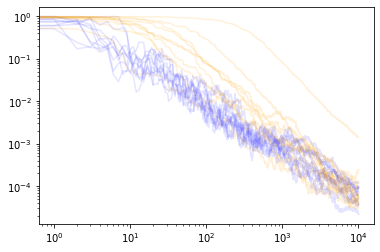

In [29]:
loss_acSgd = []
loss_sgd = []
TRIALS = 10
for i in tqdm(range(TRIALS)):
    oja = run_test_case(test_cases[1], None, AcSGD_with_decreasing_step, better_params[-1][1], False)
    oja_sgd = run_test_case(test_cases[1], None, SGD_with_decreasing_step, {'lr': 1, 'beta':1}, False)
    
    real_w = max_eigenvec(test_cases[1]['A']) 

    loss_acSgd.append(oja.loss_history(real_w))
    loss_sgd.append(oja_sgd.loss_history(real_w))
    
for i in range(TRIALS):
    plt.loglog(loss_acSgd[i], color='blue', alpha=0.1)
    plt.loglog(loss_sgd[i], color='orange', alpha=0.15)